# Modeling an HHL Algorithm to Solve a Set of Linear Equations

Solving linear equations appears in many research, engineering, and design fields. For example, many physical and financial models, from fluid dynamics to portfolio optimization, are described by partial differential equations, which are typically treated by numerical schemes, most of which are eventually transformed to a set of linear equations.

The HHL algorithm [[1](#HHL)] is a quantum algorithm for solving a set of linear equations. It is one of the fundamental quantum algorithms that is expected to give a speedup over its classical counterpart.


A set of linear equations of size $N$ is represented by an $N\times N$ matrix and a vector $b$ of size $N$,
$$
A\vec{x} = \vec{b},
$$
where the solution to the problem is designated by the solution variable $\vec{x}$.

For simplicity, the demo below treats a usecase where $\vec{b}$ is a normalized vector $|\vec{b}|=1$, and $A$ is an Hermitian matrix of size $2^n\times 2^n$, whose eigenvalues are in the interval $(0,1)$. Generalizations to other usecases are discussed at the end of this demo.

## 1. Defining a Specific Problem

Start by defining the specific problem.

In [1]:
import numpy as np

A = np.array(
    [
        [0.28, -0.01, 0.02, -0.1],
        [-0.01, 0.5, -0.22, -0.07],
        [0.02, -0.22, 0.43, -0.05],
        [-0.1, -0.07, -0.05, 0.42],
    ]
)

b = np.array([1, 2, 4, 3])
b = b / np.linalg.norm(b)

print("A =", A, "\n")
print("b =", b)

# verifying that the matrix is symmetric and has eigenvalues in [0,1)
if not np.allclose(A, A.T, rtol=1e-6, atol=1e-6):
    raise Exception("The matrix is not symmetric")
w, v = np.linalg.eig(A)
for lam in w:
    if lam < 0 or lam > 1:
        raise Exception("Eigenvalues are not in (0,1)")

A = [[ 0.28 -0.01  0.02 -0.1 ]
 [-0.01  0.5  -0.22 -0.07]
 [ 0.02 -0.22  0.43 -0.05]
 [-0.1  -0.07 -0.05  0.42]] 

b = [0.18257419 0.36514837 0.73029674 0.54772256]


## 2. Defining Quantum and Classical Functions

The quantum program below has to encode the unitary matrix $U=e^{iA}$. For this, you have to decompose the matrix $A$ into a sum of Pauli strings. This is a completely classical pre-processing that can be done with a naive decomposition. More efficient decompositions can be devised. Another classical function which allows to move from a list of Pauli strings and coefficients to `PauliTerm` type is also useful.

In addition, it will be essential to work with a flexible-QPE function, which allows a flexible and efficient implementation of this function block.

### 2.1 Pauli Decomposition

Define the `lcu_naive` auxiliary function for the classical pre-processing: decomposing a matrix into the sum of Pauli strings.

In [2]:
from itertools import product

from numpy import kron

Paulidict = {
    "I": np.array([[1, 0], [0, 1]], dtype=np.complex128),
    "Z": np.array([[1, 0], [0, -1]], dtype=np.complex128),
    "X": np.array([[0, 1], [1, 0]], dtype=np.complex128),
    "Y": np.array([[0, -1j], [1j, 0]], dtype=np.complex128),
}


# generate all combinations of Pauli strings of size n
def generate_all_pauli_strings(seq, n):
    for s in product(seq, repeat=n):
        yield "".join(s)


# convert a Paulistring of size n to 2**n X 2**n matrix
def pauli_string_2mat(seq):
    myPmat = Paulidict[seq[0]]
    for p in seq[1:]:
        myPmat = kron(myPmat, Paulidict[p])
    return myPmat


# Hilbert-Schmidt-Product of two matrices M1, M2
def hilbert_schmidt(M1, M2):
    return (np.dot(M1.conjugate().transpose(), M2)).trace()


# Naive decomposition, running over all HS products for all Pauli strings
def lcu_naive(H):
    assert H.shape[0] == H.shape[1], "matrix is not square"
    assert H.shape[0] != 0, "matrix is of size 0"
    assert H.shape[0] & (H.shape[0] - 1) == 0, "matrix size is not 2**n"

    n = int(np.log2(H.shape[0]))
    myPualiList = list(generate_all_pauli_strings("IZXY", n))

    mylist = []

    for pstr in myPualiList:
        co = (1 / 2**n) * hilbert_schmidt(pauli_string_2mat(pstr), H)
        if co != 0:
            mylist = mylist + [(pstr, co)]

    return mylist

### 2.2 Parser to the `PauliTerm` struct

Define the `pauli_operator_to_hamiltonian` auxiliary function that takes a list of Pauli strings and coefficients, and returns the corresponding struct to be entered into the Hamiltonian dynamics.

In [3]:
from typing import cast

from classiq import Pauli, PauliTerm

my_list = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}


def pauli_str_to_enums(pauli):
    return [my_list[s] for s in pauli]


def pauli_operator_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]

### 2.3 A Matrix Inversion Function with Flexible QPE

Define a quantum matrix inversion function `my_matrix_inversion_flexible`, which gets a unitary operand to implement $e^{iA}$, a `precision` integer for the eigenvalues, and a quantum variable `state` for the $|\vec{b}\rangle$ vector. The function returns the normalized solution:
$$
C |A^{-1}\vec{b}||A^{-1}\vec{b}\rangle|1\rangle + \tilde{C} |{\rm garbage}\rangle|0\rangle,
$$
where $\tilde{C}$ and $|{\rm garbage}\rangle$ are irrelevant quantities, as the solution is entangled with the `indicator` output qubit at state $|1\rangle$.
The normalization coefficient $C$, which guarantees that the amplitudes are normalized, can be taken as the lower possible eigenvalue that can be resolved with the QPE:
$$
C=1/2^{\rm precision}.
$$

Comments:
* Use the built-in `qpe_flexible` function, see [Flexible QPE tutorial](https://docs.classiq.io/latest/tutorials/tutorials/high-level-modeling-flexible-qpe/high-level-modeling-flexible-qpe/ ).
* The built-in construct to define an amplitude loading is designated by `*=`.

In [4]:
from classiq import (
    Output,
    QArray,
    QBit,
    QCallable,
    QNum,
    QParam,
    allocate,
    allocate_num,
    qfunc,
    qpe_flexible,
    within_apply,
)


@qfunc
def simple_eig_inv(phase: QNum, indicator: Output[QBit]):
    allocate(1, indicator)
    indicator *= (1 / 2**phase.size) / phase


@qfunc
def my_matrix_inversion_flexible(
    unitary_with_power: QCallable[QParam[int], QArray[QBit]],
    precision: QParam[int],
    state: QArray[QBit],
    indicator: Output[QBit],
) -> None:
    phase = QNum("phase")
    allocate_num(precision, False, precision, phase)
    within_apply(
        lambda: qpe_flexible(
            unitary_with_power=lambda k: unitary_with_power(k, state), phase=phase
        ),
        lambda: simple_eig_inv(phase=phase, indicator=indicator),
    )

## 3. Modelling an HHL Algorithm

This tutorial gives instructions on building an HHL algorithm and presents the theory of the algorithm. The algorithm consists of 4 steps:
1) State preparation of the RHS vector $\vec{b}$.
2) QPE for the unitary matrix $e^{2\pi iA}$, which encodes eigenvalues on a quantum register of size $m$.
3) An inversion algorithm that loads amplitudes according to the inverse of the eigenvalue registers.
4) An inverse QPE with the parameters in (2).

### 3.1 State Preparation for the Vector $\vec{b}$

The first stage of the HHL algorithm is to load the normalized RHS vector $\vec{b}$ into a quantum register:
$$
|0\rangle_n \xrightarrow[{\rm SP}]{} \sum^{2^n-1}_{i=0}b_i|i\rangle_n
$$
where $|i\rangle$ are states in the computational basis.

**The relevant built-in function is the `prepare_amplitudes` one, which gets $2^n$ values of $\vec{b}$, as well as an upper bound for its functional error through the `bound` parameter.**

### 3.2 Quantum Phase Estimation (QPE) for the Hamiltonian Evolution $U=e^{2\pi i A }$

The QPE function block, which is at the heart of the HHL algorithm, operates as follows: Unitary matrices have eigenvalues of norm 1, and thus are of the form $e^{2\pi i \lambda}$, with $0\leq\lambda<1$. For a quantum state $|\psi\rangle_n$, prepared in an eigenvalue of some unitary matrix $U$ of size $2^n\times 2^n$, the QPE algorithm encodes the corresponding  eigenvalue into a quantum register:
$$
|0\rangle_m|\psi\rangle_n \xrightarrow[{\rm QPE}(U)]{} |\lambda\rangle_m|\psi\rangle_n,
$$
where $m$ is the precision of the binary representation of $\lambda$, $\lambda=\frac{1}{2^m}\sum^{2^m-1}_{k=0}\lambda^{(k)}2^k$ with $\lambda^{(k)}$ being the state of the $k$-th qubit.

In the HHL algorithm a QPE for the unitary $U=e^{2\pi i A }$ is applied. The mathematics: First, note that the eigenvectors of $U$ are the ones of the matrix $A$, and that the corresponding eigenvalues $\lambda$ defined for $U=e^{2\pi i A }$ are the eigenvalues of $A$. Second, represent the prepared state in the basis given by the eigenvalues of $A$. This is merely a mathematical transformation; with no algorithmic considerations here. If the eigenbasis of $A$ is given by the set $\{|\psi_j\rangle_n \}^{2^n-1}_{j=0}$, then
$$
\sum^{2^n-1}_{i=0}b_i|i\rangle_n = \sum^{2^n-1}_{j=0}\beta_j|\psi_j\rangle_n.
$$
Applying the QPE stage gives
$$
|0\rangle_m \sum^{2^n-1}_{j=0}\beta_j|\psi_j\rangle_n \xrightarrow[{\rm QPE}]{}  \sum^{2^n-1}_{j=0}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n.
$$

For the QPE you are going to use Classiq's `suzuki-trotter` function of order 1 for Hamiltonian evolution $e^{-i H t}$. This function is an approximated one, where its `repetitions` parameter controls its error. For a QPE algorithm with size $m$ a series of controlled-unitaries $U^{2^s}$ $0 \leq s \leq m-1$ are applied, for each of which we would like to pass a different `repetitions` parameter depth (to keep a roughly same error, the repetitions for approximating $U=e^{2\pi i 2^s A }$ is expected to be $\sim 2^s$ larger then the repetitions of $U=e^{2\pi i A }$). In Classiq this can be done by working with a flexiable-QPE, and passing a "rule" for how to exponentiate each step within the QPE.

#### 3.2.1 Defining a Powered Hamiltonian Evolution

Define the inner quantum  call to be used within the flexible QPE: a Suzuki Trotter of order 1, whose repetitions parameter grows by some constant factor proportional to the evolution coefficient. 

In [5]:
from typing import List

from classiq import suzuki_trotter
from classiq.qmod.symbolic import ceiling, log


@qfunc
def suzuki_trotter1_with_power_logic(
    hamiltonian: QParam[List[PauliTerm]],
    pw: QParam[int],
    r0: QParam[int],
    reps_scaling_factor: QParam[float],
    evolution_coefficient: QParam[float],
    target: QArray[QBit],
) -> None:
    suzuki_trotter(
        hamiltonian,
        evolution_coefficient=evolution_coefficient * pw,
        order=1,
        repetitions=r0 * ceiling(reps_scaling_factor ** (log(pw, 2))),
        qbv=target,
    )

### 3.3 Eigenvalue Inversion

The next step in the HHL algorithm is to pass the inverse of the eigenvalue registers into their amplitudes, using the Amplitude Loading (AL) construct.
Given a function $f:[0,1)\rightarrow [-1,1]$, it implements $|0\rangle|\lambda\rangle_m \xrightarrow[{\rm AL}(f)]{} f(\lambda)|1\rangle|\lambda\rangle_m+\sqrt{1-f^2(\lambda)}|0\rangle|\lambda\rangle_m$. For the HHL algorithm, apply an AL with $f=C/x$ where $C$ is a lower bound for the minimal eigenvalue of $A$.
Applying this AL gives
$$
\sum^{2^n-1}_{j=0}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n \xrightarrow[{\rm AL}(C/x)]{}
|0\rangle\left(\sum^{2^n-1}_{j=0}\sqrt{1-\frac{C^2}{\lambda^2_j}}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n\right)+
|1\rangle\left(\sum^{2^n-1}_{j=0}\frac{C}{\lambda_j}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n\right),
$$


where $C$ is a normalization coefficient.

### 3.4 Inverse QPE

As the final step in the HHL model, clean the QPE register by applying an inverse-QPE. (Note that it is not guaranteed that this register is completely cleaned; namely, that all the qubits in the QPE register return to zero after the inverse-QPE. Generically they are all zero with very high probability).

In this model we will simply call the QPE function with the same parameters in stage 2. This is how the quantum state looks now
$$
 |0\rangle\left(\sum^{2^n-1}_{j=0}\sqrt{1-\frac{C^2}{\lambda^2_j}}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n\right)+
|1\rangle\left(\sum^{2^n-1}_{j=0}\frac{C}{\lambda_j}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n\right)
\xrightarrow[{\rm inv-QPE}(U)]{}
 |0\rangle_m|0\rangle\left(\sum^{2^n-1}_{j=0}\sqrt{1-\frac{C^2}{\lambda^2_j}}\beta_j  |\psi_j\rangle_n\right)+
|0\rangle_m|1\rangle\left(\sum^{2^n-1}_{j=0}\frac{C}{\lambda_j}\beta_j  |\psi_j\rangle_n\right)
$$

The state entangled with $|1\rangle$ stores the solution to our problem (up to some normalization problem)
$$
\sum^{2^n-1}_{j=0} \frac{C}{\lambda_j}\beta_j  \vec{\psi_j} = C\vec{x}.
$$


---


**In this notebook, steps 3.2-3.4 are encapsulated into a single user defined quantum function, `my_matrix_inversion_flexible`, defined in Sec. (2.4)**


---

### 3.5 The HHL Model

First, use the auxiliary function to decompose the matrix $A$ for the specific usecase. The variable `paulis` holds the list of Pauli strings that represents our matrix. The number of qubits to represent the matrix is stored in the variable `n`.

In [6]:
paulis = lcu_naive(A)
n = len(paulis[0][0])
print("Pauli strings list: \n")
for p in paulis:
    print(p[0], ": ", np.round(p[1], 3))

print("\n Number of qubits for matrix representation =", n)

Pauli strings list: 

II :  (0.408+0j)
IZ :  (-0.052+0j)
IX :  (-0.03+0j)
ZI :  (-0.017+0j)
ZZ :  (-0.057+0j)
ZX :  (0.02+0j)
XI :  (-0.025+0j)
XZ :  (0.045+0j)
XX :  (-0.16+0j)
YY :  (-0.06+0j)

 Number of qubits for matrix representation = 2


Build the quantum model calling the four quantum functions described above:

In [7]:
from classiq import Output, create_model, prepare_amplitudes, synthesize
from classiq.qmod.symbolic import floor

# parameters for the amplitude preparation
amplitudes = b.tolist()
SP_ERROR = 0.0
# parameters for the QPE
QPE_SIZE = 4
R0 = 4
REPS_SCALING_FACTOR = 1.8


@qfunc
def main(
    res: Output[QArray[QBit, floor(log(len(amplitudes), 2))]],
    indicator: Output[QBit],
) -> None:
    prepare_amplitudes(amplitudes, SP_ERROR, res)
    my_matrix_inversion_flexible(
        unitary_with_power=lambda pw, target: suzuki_trotter1_with_power_logic(
            hamiltonian=pauli_operator_to_hamiltonian(paulis),
            pw=pw,
            evolution_coefficient=-2 * np.pi,
            r0=R0,
            reps_scaling_factor=REPS_SCALING_FACTOR,
            target=target,
        ),
        precision=QPE_SIZE,
        state=res,
        indicator=indicator,
    )

This tutorial compares the classical and quantum solutions, so execute the resulting circuit on a statevector simulator. To define this part of the model, set `Sample` and `ExecutionPreferences` of a statevector simulator.

In [8]:
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences
from classiq.synthesis import set_execution_preferences

backend_preferences = ClassiqBackendPreferences(
    backend_name="aer_simulator_statevector"
)
qmod_hhl = create_model(main)

qmod_hhl = set_execution_preferences(
    qmod_hhl,
    execution_preferences=ExecutionPreferences(
        num_shots=1, backend_preferences=backend_preferences
    ),
)

In [9]:
from classiq import write_qmod

write_qmod(qmod_hhl, "hhl", decimal_precision=10)

#### 3.5.1 Synthesizing the Model

In [10]:
from classiq import synthesize

qprog_hhl = synthesize(qmod_hhl)

In [11]:
from classiq import show

show(qprog_hhl)

Opening: https://platform.classiq.io/circuit/be949406-e960-4552-a210-a86a646ca28b?version=0.38.0.dev42%2Bfd36e2c41c


In [12]:
from classiq import QuantumProgram

circuit_hhl = QuantumProgram.from_qprog(qprog_hhl)
print("depth = ", circuit_hhl.transpiled_circuit.depth)

depth =  5074


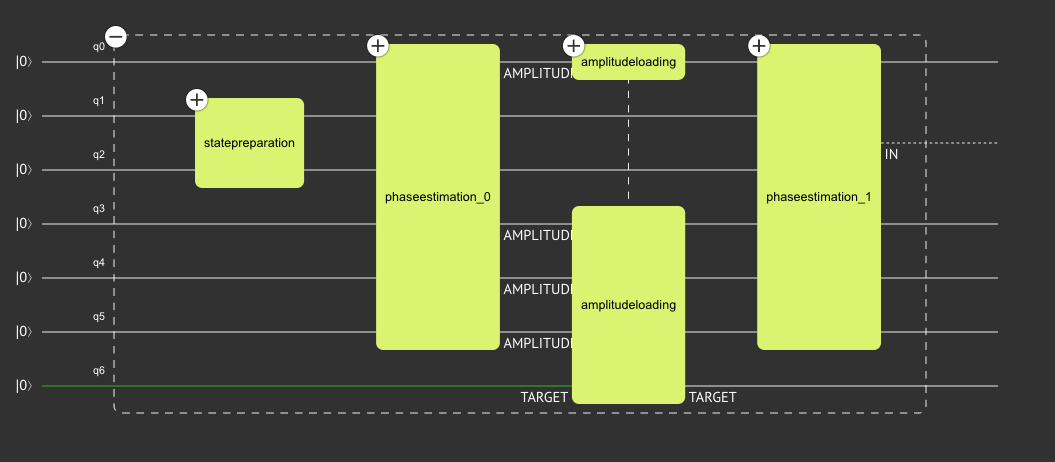

### 3.6 Executing and Verifying the Result Via the Statevector Simulator

Execute the quantum program. Recall that you chose a statevector simulator because you want the exact solution.

In [13]:
from classiq import execute

results = execute(qprog_hhl).result()

In [14]:
from classiq.execution import ExecutionDetails

res_hhl = results[0].value

Read the specific results given in the `res` register defined in the model, caring only for entries where the target register is 1.

In [15]:
total_q = circuit_hhl.data.width  # total number of qubits of the whole circuit

Read the qubit allocation of the relevant registers.

In [16]:
target_pos = res_hhl.physical_qubits_map["indicator"][0]  # position of control qubit

sol_pos = list(res_hhl.physical_qubits_map["res"])  # position of solution

phase_pos = [
    total_q - k - 1 for k in range(total_q) if k not in sol_pos + [target_pos]
]  # Finds the position of the “phase” register and flips for endianness, as you will use the indices to read directly from the string

Define a run over all the relevant strings holding the solution. The solution vector will be inserted into the variable `qsol`. Factor out $C=1/2^m$.

In [17]:
qsol = [
    np.round(parsed_state.amplitude / (1 / 2**QPE_SIZE), 5)
    for solution in range(2**n)
    for parsed_state in res_hhl.parsed_state_vector
    if parsed_state["indicator"] == 1.0
    and parsed_state["res"] == solution
    and [parsed_state.bitstring[k] for k in phase_pos]
    == ["0"]
    * QPE_SIZE  # this takes the entries where the “phase” register is at state zero
]

#### 3.6.1 Comparing classical and quantum solutions.

Note that the HHL algorithm returns a statevector result up to some global phase (coming from transpilation or from the quantum functions themselves). Therefore, to compare with the classical solution, correct for this global phase.

In [18]:
sol_classical = np.linalg.solve(A, b)
global_phase = np.angle(qsol)
qsol_corrected = np.real(qsol / np.exp(1j * global_phase))
print("classical:  ", sol_classical)
print("HHL:        ", qsol_corrected)
print(
    "relative distance:  ",
    round(
        np.linalg.norm(sol_classical - qsol_corrected)
        / np.linalg.norm(sol_classical)
        * 100,
        1,
    ),
    "%",
)

classical:   [1.3814374  2.50585064 3.19890483 2.43147877]
HHL:         [1.4399586  2.57143349 3.26031736 2.45618776]
relative distance:   2.2 %


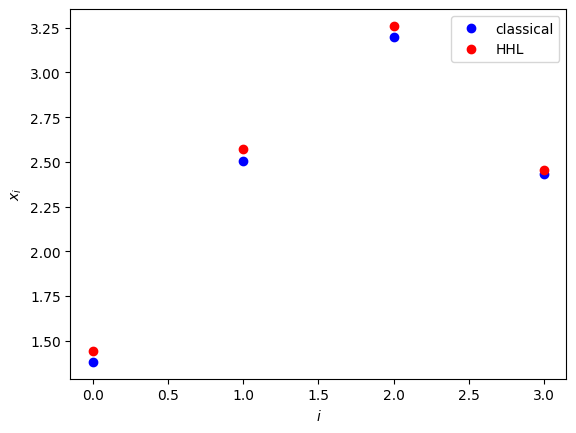

In [19]:
import matplotlib.pyplot as plt

plt.plot(sol_classical, "bo", label="classical")
plt.plot(qsol_corrected, "ro", label="HHL")
plt.legend()
plt.xlabel("$i$")
plt.ylabel("$x_i$")
plt.show()

**The lines below verifies that there is no functional error, which might come from changing endianness in Model or Execution.**

In [20]:
if np.linalg.norm(sol_classical - qsol_corrected) / np.linalg.norm(sol_classical) > 0.1:
    raise Exception(
        "The HHL solution is too far from the classical one, please verify your algorithm"
    )

## 4. Generalizations

The usecase treated above is a canonical one, assuming the following properties:
1) The RHS vector $\vec{b}$ is normalized.
2) The matrix $A$ is an Hermitian one.
3) The matrix $A$ is of size $2^n\times 2^n $.
4) The eigenvalues of $A$ are in the range $(0,1)$.

However, any general problem that does not follow these conditions can be resolved as follows:

1) As preprocessing, normalize $\vec{b}$ and then return the normalization factor as a post-processing
2) Symmetrize the problem as follows:
$$
\begin{pmatrix}
0 & A^T \\
A & 0
\end{pmatrix}
\begin{pmatrix}
\vec{b}  \\
0
\end{pmatrix}
=
\begin{pmatrix}
0  \\
\vec{x}
\end{pmatrix}.
$$
This increases the number of qubits by 1.
3) Complete the matrix dimension to the closest $2^n$ with an identity matrix. The vector $\vec{b}$ will be completed with zeros.
$$
\begin{pmatrix}
A & 0 \\
0 & I
\end{pmatrix}
\begin{pmatrix}
\vec{b}  \\
0
\end{pmatrix}
=
\begin{pmatrix}
\vec{x}  \\
0
\end{pmatrix}.
$$
4) If the eigenvalues of $A$ are in the range $[-w_{\min},w_{\max}]$ you can employ transformations to the exponentiated matrix that enters into the Hamiltonian simulation, and then undo them for extracting the results:
$$
\tilde{A}=(A+w_{\min}I)\left(1-\frac{1}{2^{m}}\right)\frac{1}{w_{\min}+w_{\max}}.
$$
The eigenvalues of this matrix lie in the interval $[0,1)$, and are related to the eigenvalues of the original matrix via
$$
\lambda = (w_{\min}+w_{\max})\tilde{\lambda}\left[1/\left(1-\frac{1}{2^{n_{m}}}\right)\right]-w_{\min},
$$
with $\tilde{\lambda}$ being an eigenvalue of $\tilde{A}$ resulting from the QPE algorithm. This relation between eigenvalues is then used for the expression inserted into the eigenvalue inversion, via the `AmplitudeLoading` function.

## References

<a name='HHL'>[1]</a>: [Harrow, A. W., Hassidim, A., & Lloyd, S., Quantum Algorithm for Linear Systems of Equations. Physical Review Letters 103, 150502 (2009)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.103.150502).
